In [16]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
sns.set_style("darkgrid")

In [17]:
filepath = 'data/train.csv'
df = pd.read_csv(filepath)

### 資料分析


In [24]:
def stat(df):
    type_list = df.dtypes
    df_stat = pd.DataFrame(type_list,columns=["data types"])
    df_stat['Missing'] = df.isnull().sum()
    df_stat['unique'] = df.nunique()
    return df_stat
df_stat = stat(df).style.background_gradient(cmap='rainbow')
df_stat

,data types,Missing,unique
id,int64,0,15304
gender,object,0,3
age,float64,0,106
hypertension,int64,0,2
heart_disease,int64,0,2
ever_married,object,0,2
work_type,object,0,5
Residence_type,object,0,2
avg_glucose_level,float64,0,3740
bmi,float64,0,407


object     5
int64      4
float64    3
dtype: int64

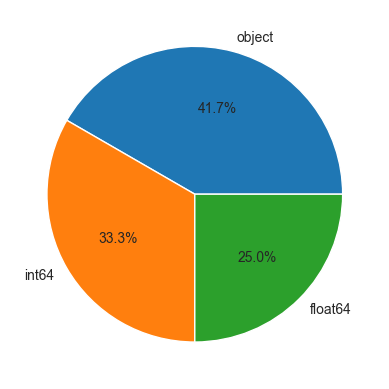

In [25]:
df.dtypes.value_counts().plot(kind="pie",autopct='%.1f%%')
df.dtypes.value_counts()

C:\Users\User\AppData\Local\Temp\ipykernel_13236\4050399445.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\User\AppData\Local\Temp\ipykernel_13236\4050399445.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\User\AppData\Local\Temp\ipykernel_13236\4050399445.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\User\AppData\Local\Temp\ipykernel_13236\4050399445.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\User\AppData\Local\Temp\ipykernel_13236\4050399445.py:4: UserWarning: Matplotlib is currently using module://ma

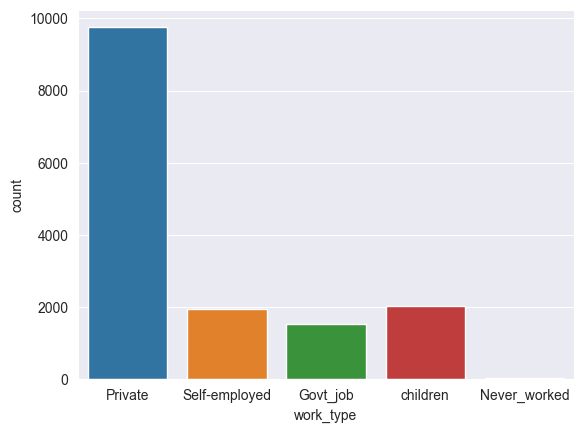

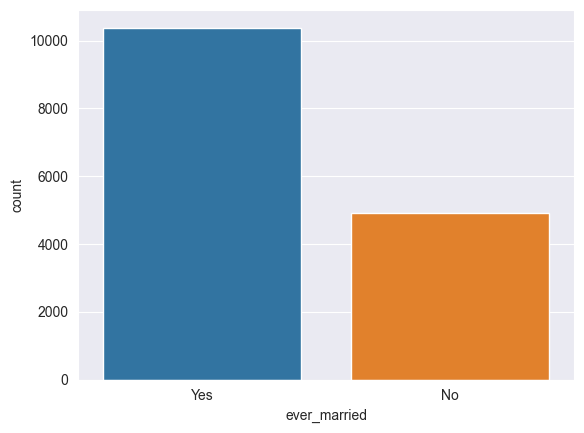

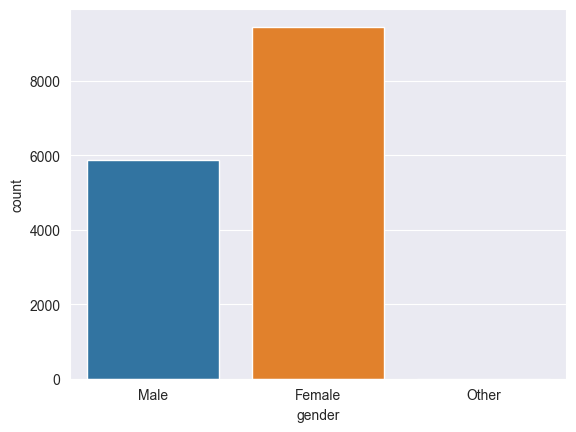

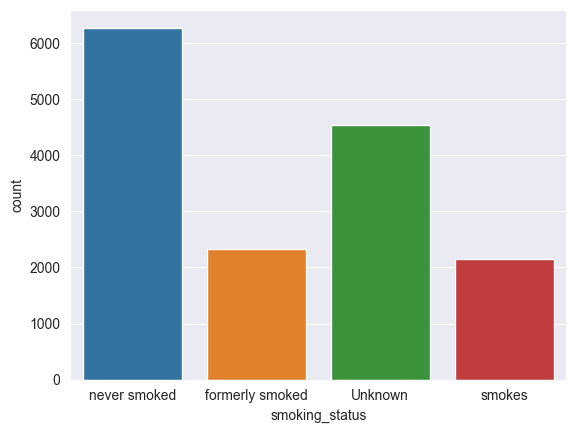

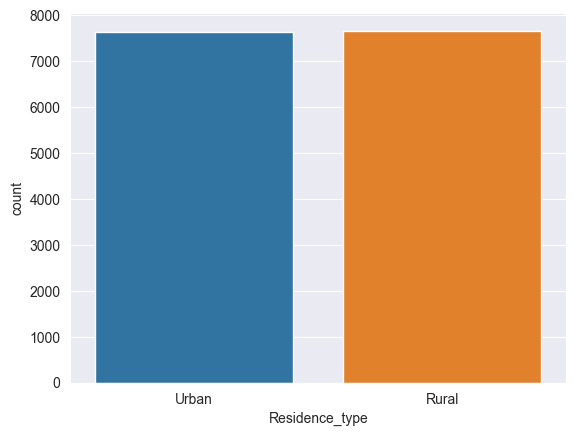

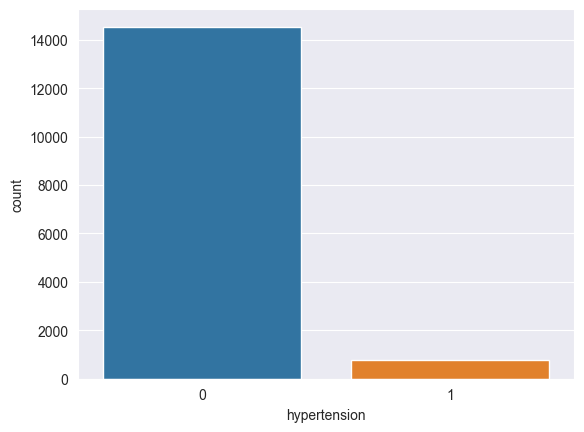

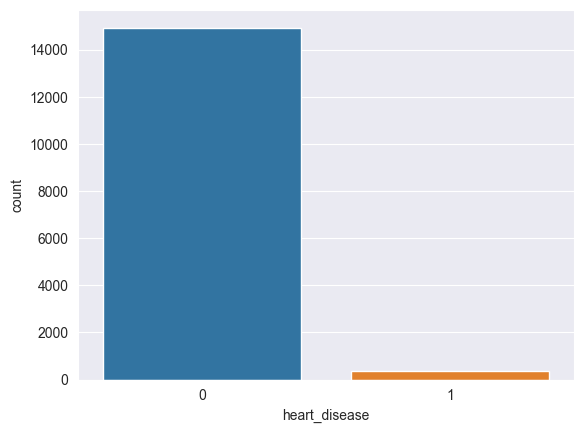

In [26]:
for i, col in enumerate(categorical_col):
    fig = plt.figure()
    ax = sns.countplot(x = col, data = df)
    fig.show()

### 資料處理

In [18]:
# 簡單的資料處理

categorical_col = set(df.columns) - set(df.select_dtypes(include=['float64', 'int64']).columns)
continuous_col = df.select_dtypes(include=['float64', 'int64']).columns
categorical_col = pd.Index(list(categorical_col) + ['hypertension', 'heart_disease', 'stroke'])
continuous_col = continuous_col.drop(['hypertension', 'heart_disease', 'stroke', 'id'])
print('categorical column:\n ', categorical_col)
print('continuous column:\n ', continuous_col)

categorical_col = ['work_type', 'ever_married', 'gender', 'smoking_status',
       'Residence_type', 'hypertension', 'heart_disease']

# 只取16歲以上的資料
df_16up = df[df['age'] > 15].drop(['id'], axis=1)

categorical column:
  Index(['ever_married', 'Residence_type', 'work_type', 'gender',
       'smoking_status', 'hypertension', 'heart_disease', 'stroke'],
      dtype='object')
continuous column:
  Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')


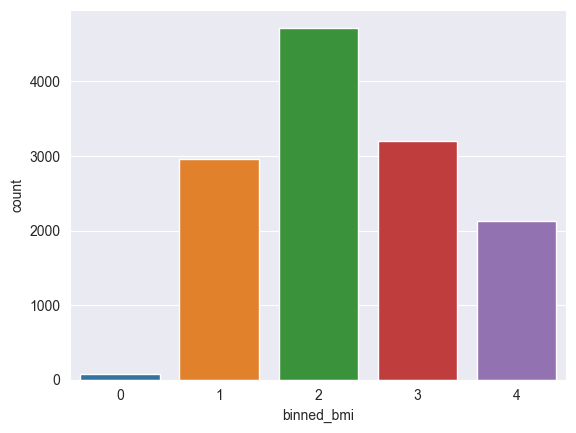

In [23]:
# binning BMI, 但是發現效果差不多, 原因在於BMI 在 feature importance當中並不特別重要

copy = df_16up.copy()
def bin_bmi(x):
    if x < 18.5:
        return 0
    elif x < 24.9:
        return 1
    elif x < 29.9: # fat 
        return 2
    elif x < 34.9: # fat 
        return 3
    else:          # fat
        return 4
copy['binned_bmi'] = copy['bmi'].map(bin_bmi)
ax = sns.countplot(data=copy, x='binned_bmi')

### baseline

(10712, 10)
(4592, 10)
(10712,)
(4592,)


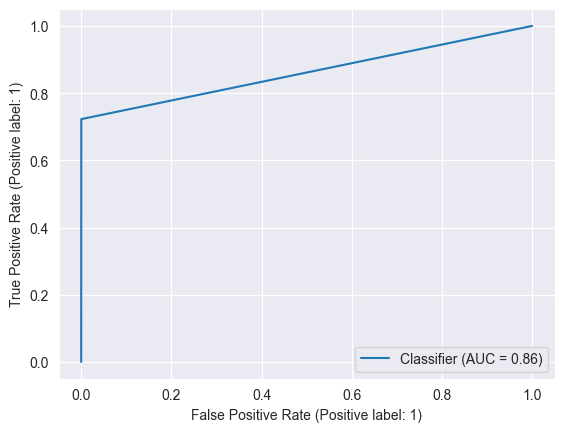

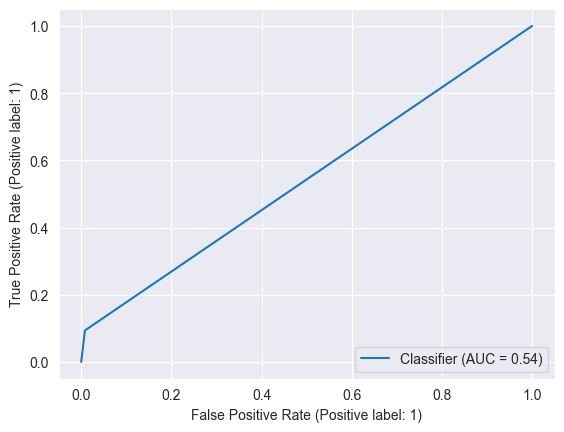

In [19]:
from xgboost import XGBClassifier

data = df.drop(['stroke', 'id'], axis=1)
data[categorical_col] = data[categorical_col].astype("category")
target = df['stroke']
train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3, random_state=45)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

xgb = XGBClassifier(tree_method="hist", enable_categorical=True)
xgb.fit(train_x, train_y)

train_y_pred = xgb.predict(train_x)
RocCurveDisplay.from_predictions(train_y, train_y_pred)
plt.show()

test_y_pred = xgb.predict(test_x)
RocCurveDisplay.from_predictions(test_y, test_y_pred)

### model-1: SMOTE + Xgboost

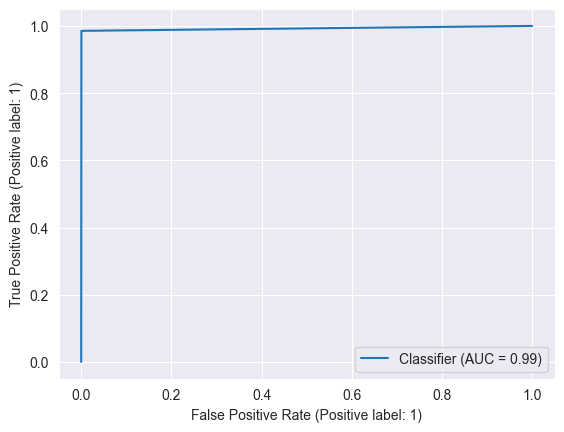

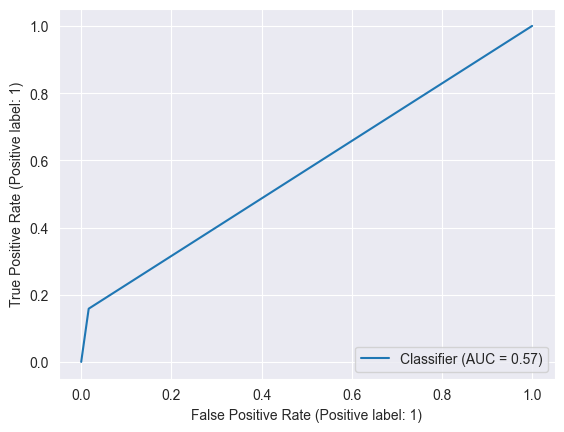

In [20]:
# 使用SMOTE方法需要使用one-hot encoding
data = pd.get_dummies(df_16up.drop(['stroke'], axis=1))
target = df_16up['stroke']

train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3, random_state=42)

from imblearn.over_sampling import SMOTE 
smote = SMOTE(random_state=42)
train_x_smo, train_y_smo = smote.fit_resample(train_x, train_y)

xgb = XGBClassifier(tree_method="hist", enable_categorical=True)
xgb.fit(train_x_smo, train_y_smo)

train_y_pred = xgb.predict(train_x_smo)
RocCurveDisplay.from_predictions(train_y_smo, train_y_pred)
plt.show()

test_y_pred = xgb.predict(test_x)
RocCurveDisplay.from_predictions(test_y, test_y_pred)

### model-2: Xgboost + scale_pos_weight

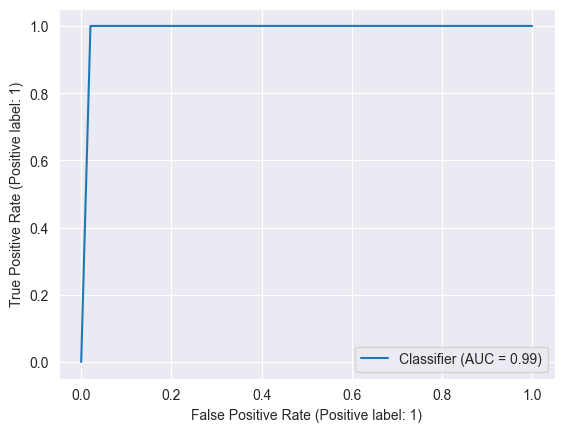

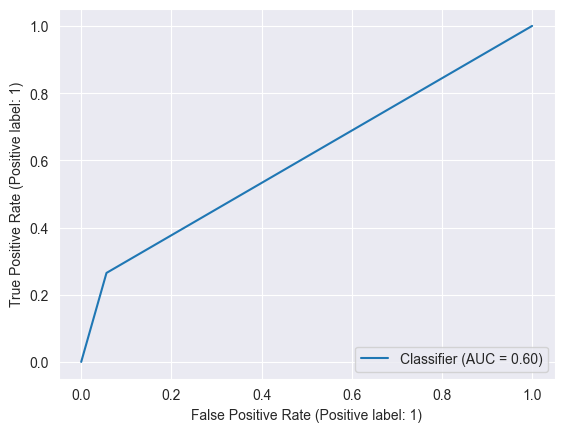

In [21]:
df_16up['stroke'].value_counts()
data = df_16up.drop(['stroke'], axis=1)
data = pd.get_dummies(data)
target = df_16up['stroke']
train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3)

from xgboost import XGBClassifier 
xgb = XGBClassifier(tree_method="hist", enable_categorical=True, scale_pos_weight=20)
xgb.fit(train_x, train_y)

train_y_pred = xgb.predict(train_x)
RocCurveDisplay.from_predictions(train_y, train_y_pred)
plt.show()

test_y_pred = xgb.predict(test_x)
RocCurveDisplay.from_predictions(test_y, test_y_pred)

### model-3: EasyEnsemble

In [3]:
from imblearn.ensemble import EasyEnsembleClassifier

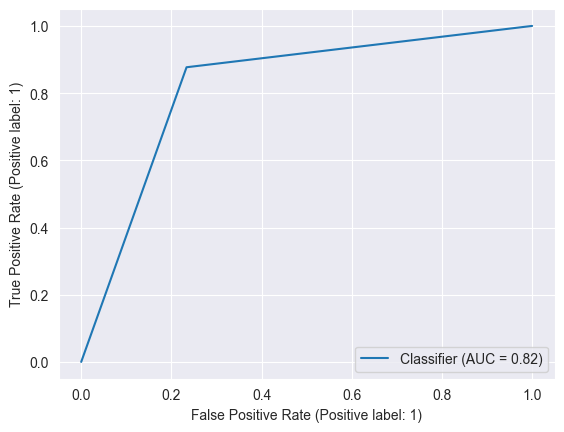

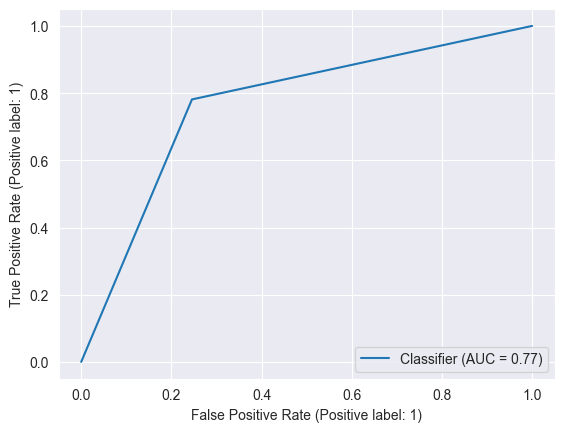

In [28]:
df_16up['stroke'].value_counts()
data = df_16up.drop(['stroke'], axis=1)
data = pd.get_dummies(data)
target = df_16up['stroke']
train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3)

eec = EasyEnsembleClassifier()
eec.fit(train_x, train_y)
test_y_pred = eec.predict(test_x)

train_y_pred = eec.predict(train_x)
RocCurveDisplay.from_predictions(train_y, train_y_pred)
plt.show()

test_y_pred = eec.predict(test_x)
RocCurveDisplay.from_predictions(test_y, test_y_pred)

In [30]:
# 列出每一個classifier的feature importance

clfs = []
feature_set = set()
for p in eec.estimators_:
    clfs.append(p[1])
for clf in clfs:
    m = {f_name:f_value for f_name, f_value in zip(eec.feature_names_in_, clf.feature_importances_) if f_value > 0}
    sorted_m = sorted(m.items(), key=lambda x:x[1], reverse=True)
    print(sorted_m)
    for item in m:
        feature_set.add(item)

[('avg_glucose_level', 0.36), ('age', 0.32), ('bmi', 0.28), ('hypertension', 0.02), ('gender_Female', 0.02)]
[('bmi', 0.34), ('avg_glucose_level', 0.28), ('age', 0.26), ('hypertension', 0.04), ('ever_married_Yes', 0.02), ('work_type_Self-employed', 0.02), ('smoking_status_formerly smoked', 0.02), ('smoking_status_smokes', 0.02)]
[('avg_glucose_level', 0.4), ('age', 0.34), ('bmi', 0.18), ('ever_married_No', 0.02), ('work_type_Govt_job', 0.02), ('smoking_status_formerly smoked', 0.02), ('smoking_status_smokes', 0.02)]
[('avg_glucose_level', 0.38), ('bmi', 0.26), ('age', 0.24), ('hypertension', 0.02), ('heart_disease', 0.02), ('work_type_Govt_job', 0.02), ('work_type_Self-employed', 0.02), ('smoking_status_formerly smoked', 0.02), ('smoking_status_smokes', 0.02)]
[('avg_glucose_level', 0.44), ('age', 0.22), ('bmi', 0.22), ('hypertension', 0.02), ('heart_disease', 0.02), ('gender_Female', 0.02), ('work_type_Govt_job', 0.02), ('work_type_Self-employed', 0.02), ('smoking_status_formerly smok